# IVDA G2: Project Prototype Coding Response

### YourZuriFlat
Tim Lui (24-755-092)
Joao Pereira Fernandes(25-743-972)
Zong Zhe Kerk (25-744-293)
Maxim Emelianov (24-748-790)

### GitHub Repo
Link goes here:

### Contributions
Tim -
Joao -
Kerk -
Maxim -

### Tasks
T1: Identify suitable apartments. Discover listings aligned with learned user preferences through regression-based ranking.  
T2: Compare apartments by attributes. Analyze trade-offs across key apartment dimensions — price, proximity to city center, etc...  
T3: Summarize model reasoning. Expose feature contributions to predicted ratings.  
T4: Calibrate regression. Establish a sufficiently labeled dataset by requiring users to rate a minimum threshold of listings on initialization.  
T5: Explore apartments. Enable users to browse the full dataset independent of model suggestions.  
T6: Relate apartment attributes. Visualize correlations within the apartment dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

ModuleNotFoundError: No module named 'numpy'

In [ ]:
df = pd.read_csv('listings.csv')
df.shape

(3301, 79)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3301 entries, 0 to 3300
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3301 non-null   float64
 1   listing_url                                   3301 non-null   object 
 2   scrape_id                                     3301 non-null   float64
 3   last_scraped                                  3301 non-null   object 
 4   source                                        3301 non-null   object 
 5   name                                          3301 non-null   object 
 6   description                                   3216 non-null   object 
 7   neighborhood_overview                         1329 non-null   object 
 8   picture_url                                   3301 non-null   object 
 9   host_id                                       3301 non-null   i

While the new dataset (79 columns) comes with more useful details, it also comes with a lot more irrelevant features. It makes more practical sense for us to first perform some cleanup in the form of elimination before beginning characterization. From our observation, there was a large percentage of missing data in 'price' (2503 non-null of 3301 rows), which we chose to handle by means of removal, given its importance.

In [ ]:
# Here, we extract columns that could be relevant for both the webApp and model training purposes
df_usable = df[['id', 'name', 'host_id', 'host_name', 'neighbourhood_group_cleansed', 'neighbourhood_cleansed', 
                'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
                'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights']].copy()

# Remove NaN rows for price, bathrooms, bedrooms, beds
df_usable = df_usable[df_usable['price'].notna()].copy()
df_usable = df_usable[df_usable['bathrooms'].notna()].copy()
df_usable = df_usable[df_usable['bedrooms'].notna()].copy()
df_usable = df_usable[df_usable['beds'].notna()].copy()
df_usable.rename(columns={'neighbourhood_group_cleansed': 'neighbourhood_group', 'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)

# Engineered feature 'distance_from_city_center'
def haversine_distance(lat1, lon1, lat2, lon2):

    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c
    
df_usable['distance_from_city_center'] = haversine_distance(df_usable['latitude'], df_usable['longitude'], 47.3769, 8.5417)
df_usable.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2492 entries, 1 to 3300
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         2492 non-null   float64
 1   name                       2492 non-null   object 
 2   host_id                    2492 non-null   int64  
 3   host_name                  2433 non-null   object 
 4   neighbourhood_group        2492 non-null   object 
 5   neighbourhood              2492 non-null   object 
 6   latitude                   2492 non-null   float64
 7   longitude                  2492 non-null   float64
 8   property_type              2492 non-null   object 
 9   room_type                  2492 non-null   object 
 10  accommodates               2492 non-null   int64  
 11  bathrooms                  2492 non-null   float64
 12  bedrooms                   2492 non-null   float64
 13  beds                       2492 non-null   float64
 1

'amenities' feature was a JSON object containing multiple features, which upon explosion turned out to be over 900 unique features. Retaining all would be inefficient and leads to instability for PCA downstream, considering the possible sparse values in rare amenities. As such, we opted to keep only amenities that showed up in at least 20% of listings (46).

In [ ]:
# Blow up amenities into individual feature columns
df_usable["amenities_parsed"] = df_usable["amenities"].apply(
    lambda x: json.loads(x) if pd.notna(x) else []
)
exploded = df_usable[["amenities_parsed"]].explode("amenities_parsed")
dummies = pd.get_dummies(exploded["amenities_parsed"], prefix="amenity")
amenities_binary = dummies.groupby(exploded.index).max()
df_usable = df_usable.join(amenities_binary)

# Clean up
df_usable = df_usable.drop(columns=["amenities", "amenities_parsed"])

# Keep most frequent amenities only
amenity_cols = [col for col in df_usable.columns if col.startswith("amenity_")]
amenity_counts = df_usable[amenity_cols].sum().sort_values(ascending=False)
top_amenities = amenity_counts[amenity_counts >= 500].index.tolist()
rare_amenities = [col for col in amenity_cols if col not in top_amenities]

if rare_amenities: 
    df_usable["amenity_others"] = (df_usable[rare_amenities].max(axis=1) > 0).astype(int)
else:
    df_usable["amenity_others"] = 0

# Rebuild dataframe
df_usable = df_usable[[col for col in df_usable.columns if not col.startswith("amenity_")] + top_amenities + ["amenity_others"]]

### Data Characterization

With the final usable dataset being 2492 rows of 65 features, not all of them remain relevant to the purpose of machine learning but are retained for completeness of modelling a single item. 

Irrelevant Features for model, but still necessary for webApp
1. id
2. name
3. host_id
4. host_name
5. distance_from_city_center

For the remaining relevant features, we characterize them by visualization based on attribute type. Categorical - bar charts, Numerical - histograms/boxplots

In [ ]:
df_usable.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2492 entries, 1 to 3300
Data columns (total 65 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  2492 non-null   float64
 1   name                                2492 non-null   object 
 2   host_id                             2492 non-null   int64  
 3   host_name                           2433 non-null   object 
 4   neighbourhood_group                 2492 non-null   object 
 5   neighbourhood                       2492 non-null   object 
 6   latitude                            2492 non-null   float64
 7   longitude                           2492 non-null   float64
 8   property_type                       2492 non-null   object 
 9   room_type                           2492 non-null   object 
 10  accommodates                        2492 non-null   int64  
 11  bathrooms                           2492 non-nul

In [ ]:
df_usable.describe()

,id,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,distance_from_city_center,amenity_others
count,2.492000e+03,2.492000e+03,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000
mean,7.648664e+17,1.701740e+08,47.378478,8.532818,2.900482,1.135835,1.215891,1.626003,197.646469,7.436597,481.095506,2.431300,0.946629
std,5.665791e+17,2.058670e+08,0.018696,0.022891,1.670261,0.383978,0.788784,1.157496,392.385630,19.780844,424.136705,1.362912,0.224817
min,1.438210e+05,3.279970e+05,47.324159,8.472680,1.000000,0.000000,0.000000,0.000000,10.000000,1.000000,2.000000,0.110881,0.000000
25%,4.352536e+07,1.357066e+07,47.365167,8.516683,2.000000,1.000000,1.000000,1.000000,100.000000,1.000000,90.000000,1.380121,1.000000
50%,9.716965e+17,5.702909e+07,47.376175,8.532782,2.000000,1.000000,1.000000,1.000000,143.000000,2.000000,365.000000,2.193825,1.000000
75%,1.265130e+18,3.429300e+08,47.387840,8.548748,4.000000,1.000000,1.000000,2.000000,218.000000,5.000000,1125.000000,3.428520,1.000000
max,1.451590e+18,7.024481e+08,47.428923,8.606200,16.000000,5.000000,12.000000,17.000000,9840.000000,365.000000,1125.000000,6.578219,1.000000


Categorical attributes (multiclass)

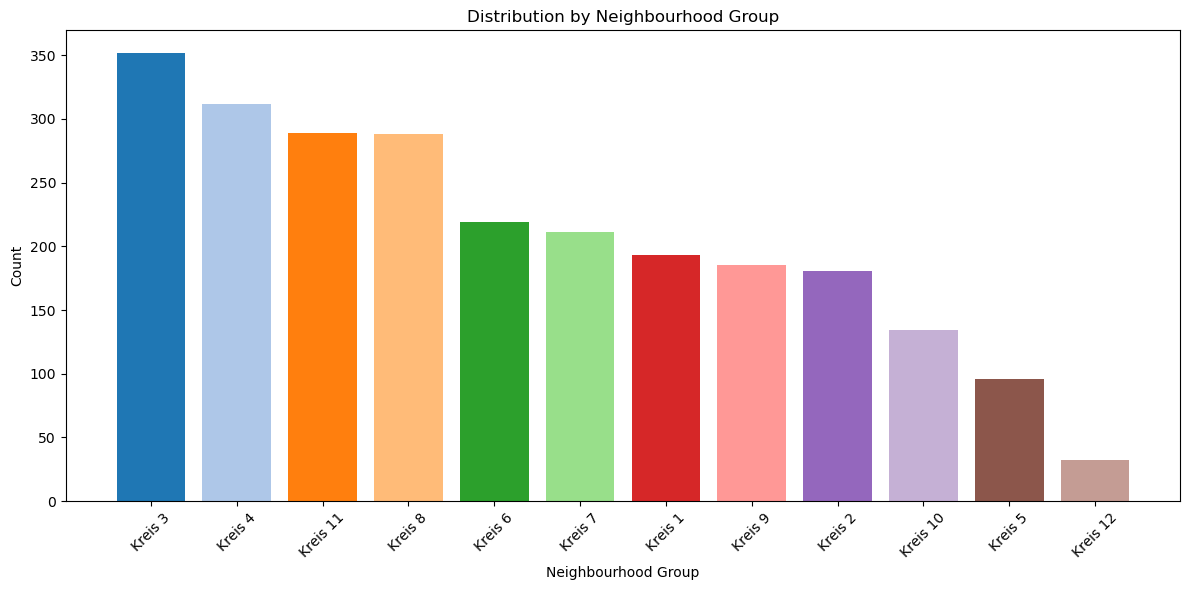

In [ ]:
# neighbourhood group
feature = 'neighbourhood_group'
counts = df_usable[feature].value_counts().reset_index()
counts.columns = [feature, 'Count']

groups = counts['neighbourhood_group'].unique()
colors = plt.cm.tab20(range(len(groups)))
color_map = dict(zip(groups, colors))

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(counts))

bars = ax.bar(x, counts['Count'], color=[color_map[g] for g in counts['neighbourhood_group']])

ax.set_xticks(x)
ax.set_xticklabels(counts[feature], rotation=45)

ax.set_xlabel('Neighbourhood Group')
ax.set_ylabel('Count')

ax.set_title('Distribution by Neighbourhood Group')
plt.tight_layout()
plt.show()

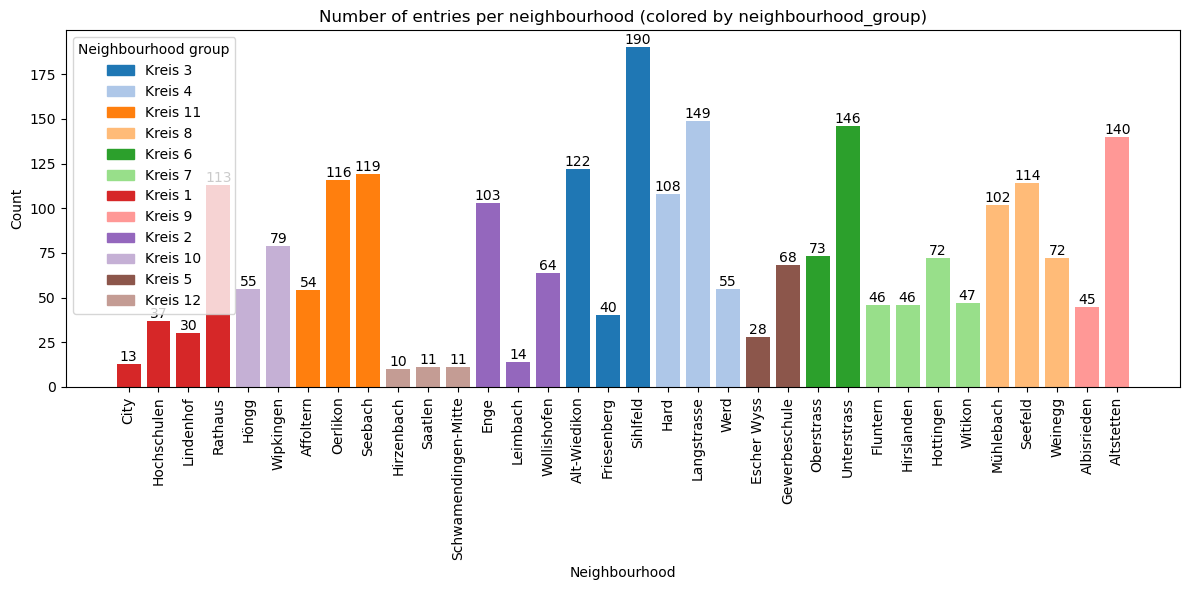

In [ ]:
counts = (
    df_usable.groupby(['neighbourhood_group', 'neighbourhood'])
      .size()
      .reset_index(name='count')
      .sort_values(['neighbourhood_group', 'neighbourhood'])
)

counts['neighbourhood'] = pd.Categorical(
    counts['neighbourhood'],
    categories=counts['neighbourhood'],
    ordered=True
)

fig, ax = plt.subplots(figsize=(12, 6))
x_pos = range(len(counts))
bars = ax.bar(
    x_pos,
    counts['count'],
    color=[color_map[g] for g in counts['neighbourhood_group']]
)

ax.set_xticks(x_pos)
ax.set_xticklabels(counts['neighbourhood'], rotation=90)
ax.set_xlabel('Neighbourhood')
ax.set_ylabel('Count')
ax.bar_label(bars)
ax.set_title('Number of entries per neighbourhood (colored by neighbourhood_group)')

handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[g]) for g in groups]
ax.legend(handles, groups, title='Neighbourhood group')

plt.tight_layout()
plt.show()

Neighbourhood Groups and Neighbourhood are not evenly distributed in the dataset. Nothing out of our expectations, given our understanding of how Airbnb operates.

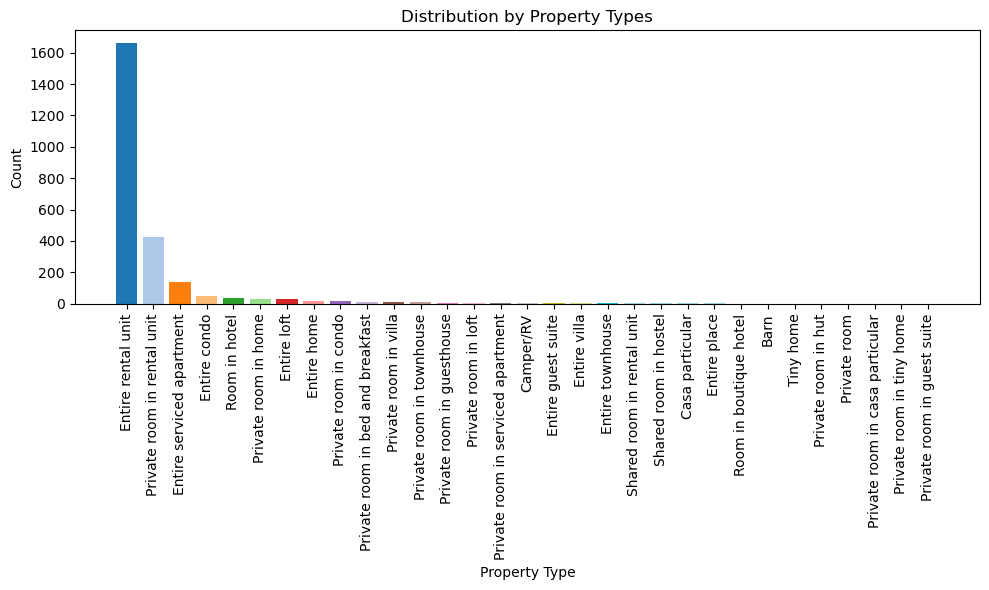

In [ ]:
feature = 'property_type'
counts = df_usable[feature].value_counts().reset_index()
counts.columns = [feature, 'Count']

groups = counts[feature].unique()
colors = plt.cm.tab20(range(len(groups)))
color_map = dict(zip(groups, colors))

fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(counts))

bars = ax.bar(x, counts['Count'], color=[color_map[g] for g in counts[feature]])

ax.set_xticks(x)
ax.set_xticklabels(counts[feature], rotation=90)

ax.set_xlabel('Property Type')
ax.set_ylabel('Count')

ax.set_title('Distribution by Property Types')
plt.tight_layout()
plt.show()

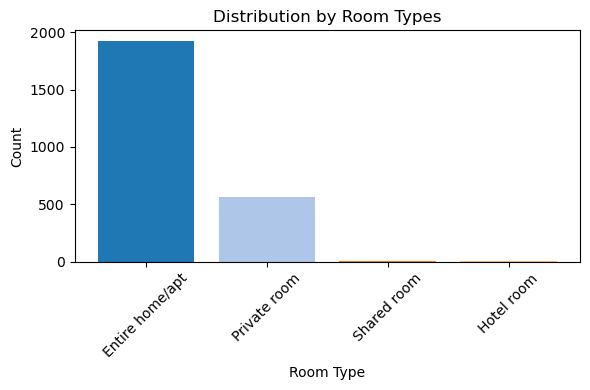

In [ ]:
feature = 'room_type'
counts = df_usable[feature].value_counts().reset_index()
counts.columns = [feature, 'Count']

groups = counts[feature].unique()
colors = plt.cm.tab20(range(len(groups)))
color_map = dict(zip(groups, colors))

fig, ax = plt.subplots(figsize=(6, 4))
x = range(len(counts))

bars = ax.bar(x, counts['Count'], color=[color_map[g] for g in counts[feature]])

ax.set_xticks(x)
ax.set_xticklabels(counts[feature], rotation=45)

ax.set_xlabel('Room Type')
ax.set_ylabel('Count')

ax.set_title('Distribution by Room Types')
plt.tight_layout()
plt.show()

Severe over-representation of entire units, homes and private rooms. Underrepresentation of Hotel rooms and Shared rooms are expected, given Airbnb. 

Categorical attributes (Binary class)

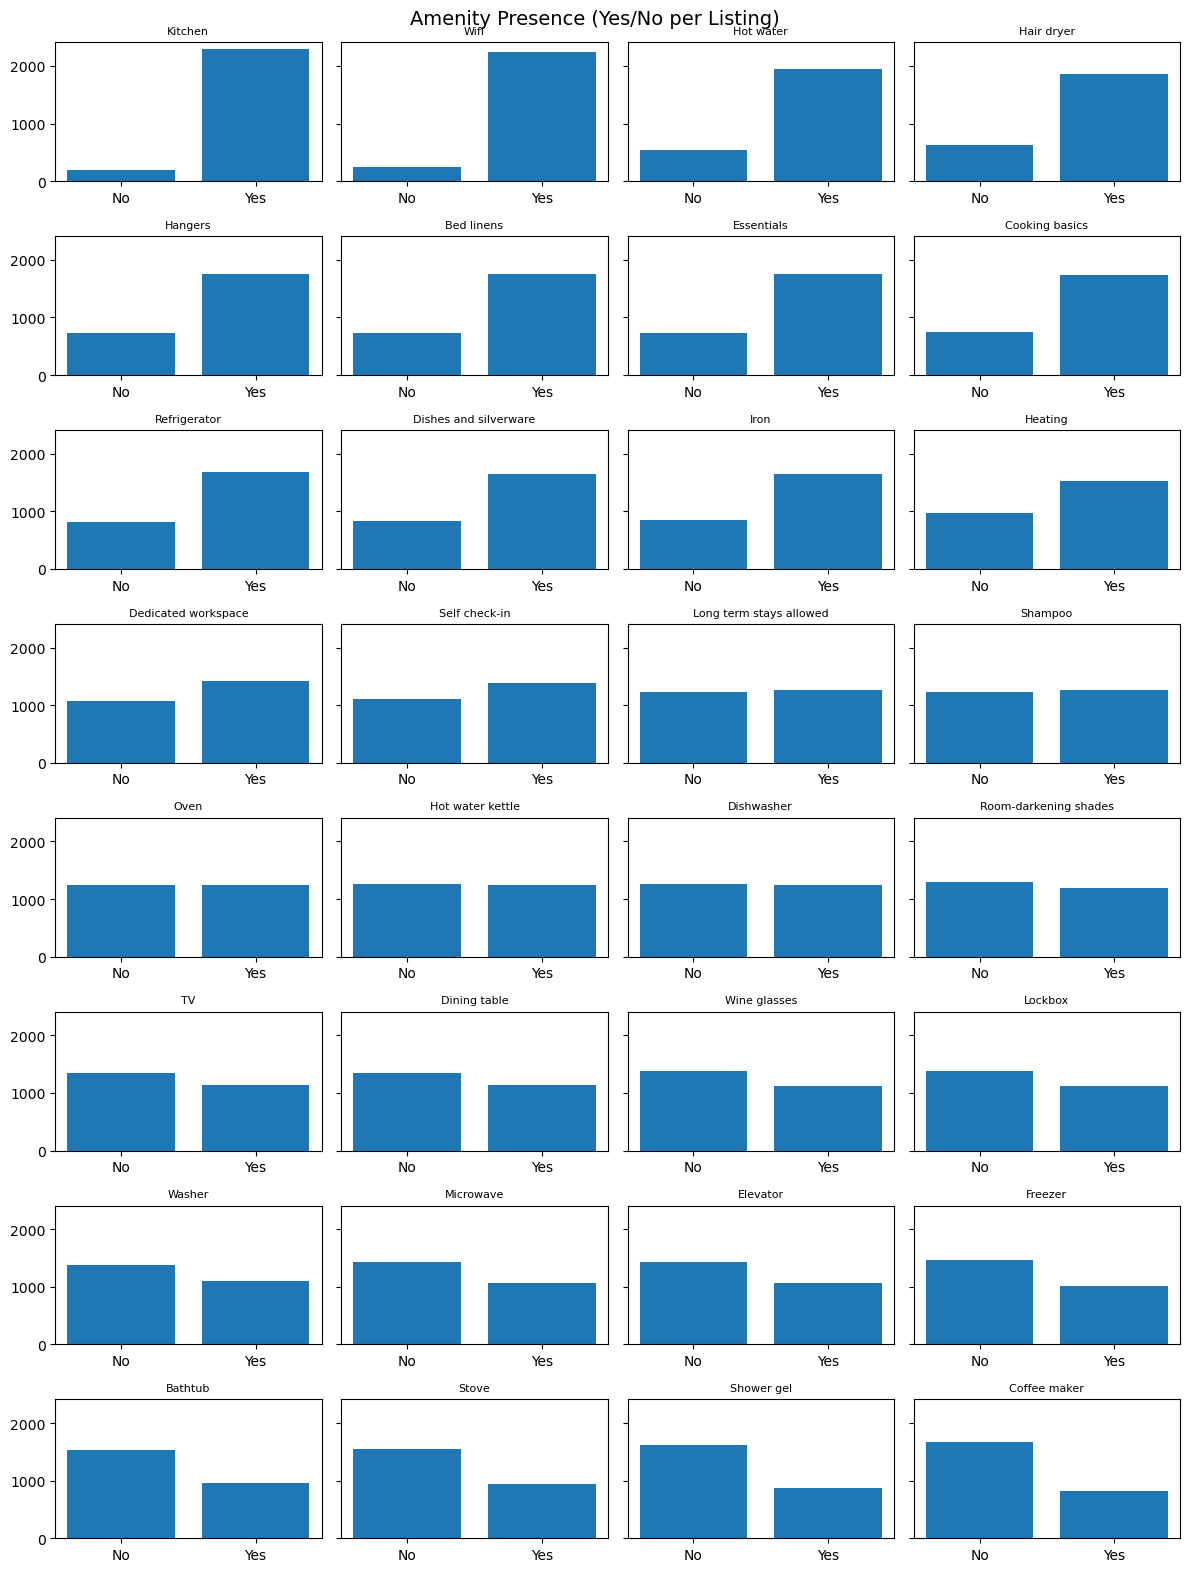

In [ ]:
# all amenities (small multiples of yes/no binary categories)
amenity_cols = [col for col in df_usable.columns if col.startswith("amenity_")]
n_amenities = len(amenity_cols)
n_cols = 4  # number of plots per row (tune this)
n_rows = 8

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2), sharey=True)
axes = axes.flatten()  # make it 1D for easier looping

for ax, col in zip(axes, amenity_cols):
    # value_counts on 0/1
    counts = df_usable[col].value_counts().sort_index()

    # Rename index for nicer labels if it's 0/1
    if list(counts.index) == [0, 1]:
        x_labels = ["No", "Yes"]
    else:
        x_labels = counts.index.astype(str)

    ax.bar(x_labels, counts.values)
    ax.set_title(col.replace("amenity_", ""), fontsize=8)
    ax.tick_params(axis="x")
    ax.tick_params(axis="y")

# Turn off any unused axes (if grid has more cells than amenities)
for ax in axes[n_amenities:]:
    ax.axis("off")

fig.suptitle("Amenity Presence (Yes/No per Listing)", fontsize=14)
plt.tight_layout()
plt.show()

Numerical attributes

Boxplot summary statistics:
Minimum: 1.00
Q1 (25th percentile): 2.00
Median (50th percentile): 2.00
Q3 (75th percentile): 4.00
Maximum: 16.00
IQR (Q3 - Q1): 2.00


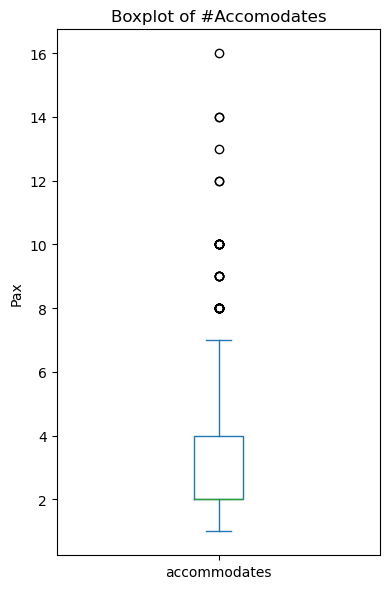

In [ ]:
feature = df_usable['accommodates']

# Compute key points
q1 = np.percentile(feature, 25)
median = np.percentile(feature, 50)
q3 = np.percentile(feature, 75)
min_val = feature.min()
max_val = feature.max()
iqr = q3 - q1

# --- Print numeric values ---
print("Boxplot summary statistics:")
print(f"Minimum: {min_val:.2f}")
print(f"Q1 (25th percentile): {q1:.2f}")
print(f"Median (50th percentile): {median:.2f}")
print(f"Q3 (75th percentile): {q3:.2f}")
print(f"Maximum: {max_val:.2f}")
print(f"IQR (Q3 - Q1): {iqr:.2f}")

plt.figure(figsize=(4, 6))
feature.plot(kind="box")
plt.title("Boxplot of #Accomodates")
plt.ylabel("Pax")
plt.tight_layout()
plt.show()

Boxplot summary statistics:
Minimum: 0.00
Q1 (25th percentile): 1.00
Median (50th percentile): 1.00
Q3 (75th percentile): 1.00
Maximum: 5.00
IQR (Q3 - Q1): 0.00


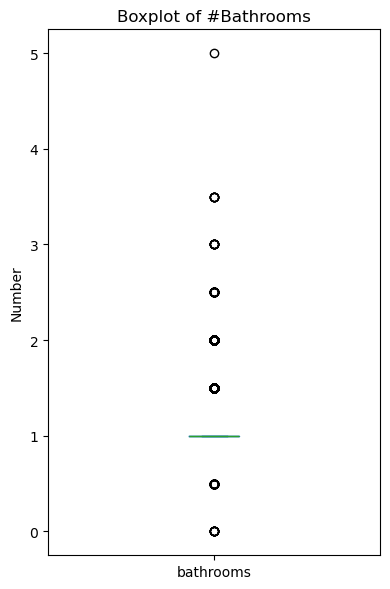

In [ ]:
feature = df_usable['bathrooms']

# Compute key points
q1 = np.percentile(feature, 25)
median = np.percentile(feature, 50)
q3 = np.percentile(feature, 75)
min_val = feature.min()
max_val = feature.max()
iqr = q3 - q1

# --- Print numeric values ---
print("Boxplot summary statistics:")
print(f"Minimum: {min_val:.2f}")
print(f"Q1 (25th percentile): {q1:.2f}")
print(f"Median (50th percentile): {median:.2f}")
print(f"Q3 (75th percentile): {q3:.2f}")
print(f"Maximum: {max_val:.2f}")
print(f"IQR (Q3 - Q1): {iqr:.2f}")

plt.figure(figsize=(4, 6))
feature.plot(kind="box")
plt.title("Boxplot of #Bathrooms")
plt.ylabel("Number")
plt.tight_layout()
plt.show()

Boxplot summary statistics:
Minimum: 0.00
Q1 (25th percentile): 1.00
Median (50th percentile): 1.00
Q3 (75th percentile): 1.00
Maximum: 12.00
IQR (Q3 - Q1): 0.00


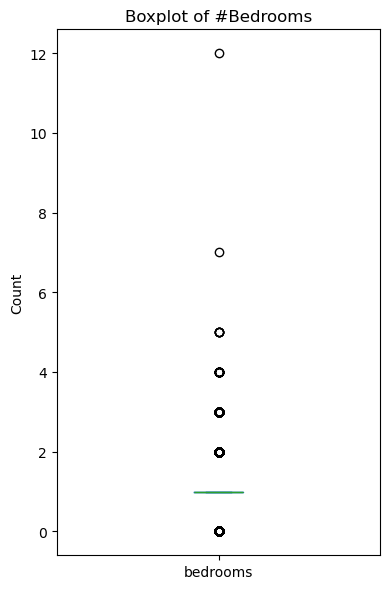

In [ ]:
feature = df_usable['bedrooms']

# Compute key points
q1 = np.percentile(feature, 25)
median = np.percentile(feature, 50)
q3 = np.percentile(feature, 75)
min_val = feature.min()
max_val = feature.max()
iqr = q3 - q1

# --- Print numeric values ---
print("Boxplot summary statistics:")
print(f"Minimum: {min_val:.2f}")
print(f"Q1 (25th percentile): {q1:.2f}")
print(f"Median (50th percentile): {median:.2f}")
print(f"Q3 (75th percentile): {q3:.2f}")
print(f"Maximum: {max_val:.2f}")
print(f"IQR (Q3 - Q1): {iqr:.2f}")

plt.figure(figsize=(4, 6))
feature.plot(kind="box")
plt.title("Boxplot of #Bedrooms")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Boxplot summary statistics:
Minimum: 0.00
Q1 (25th percentile): 1.00
Median (50th percentile): 1.00
Q3 (75th percentile): 2.00
Maximum: 17.00
IQR (Q3 - Q1): 1.00


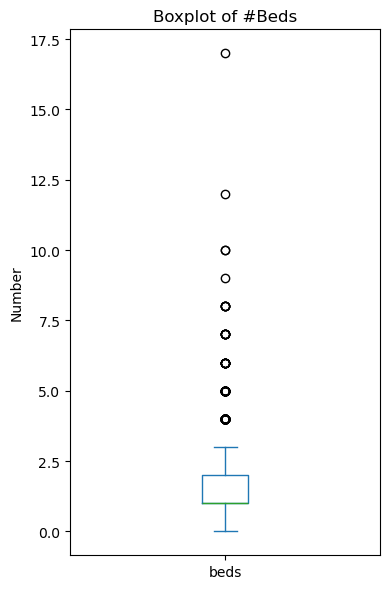

In [ ]:
feature = df_usable['beds']

# Compute key points
q1 = np.percentile(feature, 25)
median = np.percentile(feature, 50)
q3 = np.percentile(feature, 75)
min_val = feature.min()
max_val = feature.max()
iqr = q3 - q1

# --- Print numeric values ---
print("Boxplot summary statistics:")
print(f"Minimum: {min_val:.2f}")
print(f"Q1 (25th percentile): {q1:.2f}")
print(f"Median (50th percentile): {median:.2f}")
print(f"Q3 (75th percentile): {q3:.2f}")
print(f"Maximum: {max_val:.2f}")
print(f"IQR (Q3 - Q1): {iqr:.2f}")

plt.figure(figsize=(4, 6))
feature.plot(kind="box")
plt.title("Boxplot of #Beds")
plt.ylabel("Number")
plt.tight_layout()
plt.show()

0 bedrooms and/or beds are semantic outliers that are logically inconsistent, given that listings accommodates at least 1 person. Imputation will be done according to the following logic:
- Every 2 persons the listing accommodates, there should be 1 bed
- Every bed should have a bedroom

Additionally, upon inspection, a single listing with too many rooms, not logically justified by accommodates, will also be dropped.

In [ ]:
mask_beds_missing = (df_usable['beds'] == 0)
df_usable.loc[mask_beds_missing, "beds"] = (np.ceil(df_usable.loc[mask_beds_missing, 'accommodates'] / 2.0).astype(int))

mask_bedrooms_missing = (df_usable['bedrooms'] == 0)
df_usable.loc[mask_bedrooms_missing, 'bedrooms'] = df_usable.loc[mask_bedrooms_missing, 'beds'].astype(int)

mask = (df_usable["accommodates"] == 2) & (df_usable["bedrooms"] == 12)
df_usable = df_usable[~mask].copy()

Boxplot summary statistics:
Minimum: 10.00
Q1 (25th percentile): 100.00
Median (50th percentile): 143.00
Q3 (75th percentile): 218.00
Maximum: 9840.00
IQR (Q3 - Q1): 118.00


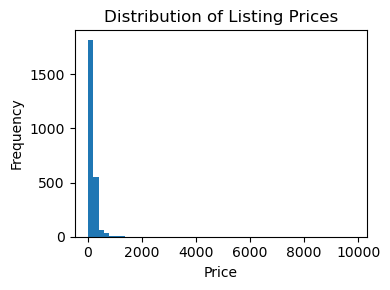

In [ ]:
feature = df_usable['price']

# Compute key points
q1 = np.percentile(feature, 25)
median = np.percentile(feature, 50)
q3 = np.percentile(feature, 75)
min_val = feature.min()
max_val = feature.max()
iqr = q3 - q1

# --- Print numeric values ---
print("Boxplot summary statistics:")
print(f"Minimum: {min_val:.2f}")
print(f"Q1 (25th percentile): {q1:.2f}")
print(f"Median (50th percentile): {median:.2f}")
print(f"Q3 (75th percentile): {q3:.2f}")
print(f"Maximum: {max_val:.2f}")
print(f"IQR (Q3 - Q1): {iqr:.2f}")

fig, ax = plt.subplots(figsize=(4, 3))

ax.hist(
    feature,
    bins=50
)

ax.set_xlabel('Price')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Listing Prices')

plt.tight_layout()
plt.show()

Most prices are between 100 and 218 (Q1 and Q3). There are some extreme values above 2000 and up to 9840 (max) which could possibl be luxury listings and are not removed.

Boxplot summary statistics:
Minimum: 1.00
Q1 (25th percentile): 1.00
Median (50th percentile): 2.00
Q3 (75th percentile): 5.00
Maximum: 365.00
IQR (Q3 - Q1): 4.00


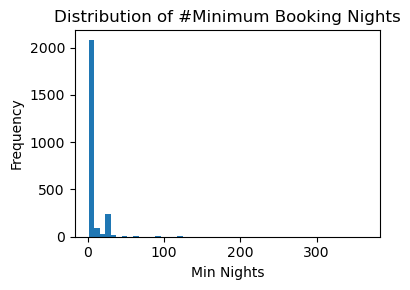

In [ ]:
feature = df_usable['minimum_nights']

# Compute key points
q1 = np.percentile(feature, 25)
median = np.percentile(feature, 50)
q3 = np.percentile(feature, 75)
min_val = feature.min()
max_val = feature.max()
iqr = q3 - q1

# --- Print numeric values ---
print("Boxplot summary statistics:")
print(f"Minimum: {min_val:.2f}")
print(f"Q1 (25th percentile): {q1:.2f}")
print(f"Median (50th percentile): {median:.2f}")
print(f"Q3 (75th percentile): {q3:.2f}")
print(f"Maximum: {max_val:.2f}")
print(f"IQR (Q3 - Q1): {iqr:.2f}")

fig, ax = plt.subplots(figsize=(4, 3))

ax.hist(
    feature,
    bins=50
)

ax.set_xlabel('Min Nights')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of #Minimum Booking Nights')

plt.tight_layout()
plt.show()

Most listings have minimum booking nights defined between 1 and 5 nights and those higher could be listings for longer term stays.

Boxplot summary statistics:
Minimum: 2.00
Q1 (25th percentile): 90.00
Median (50th percentile): 365.00
Q3 (75th percentile): 1125.00
Maximum: 1125.00
IQR (Q3 - Q1): 1035.00


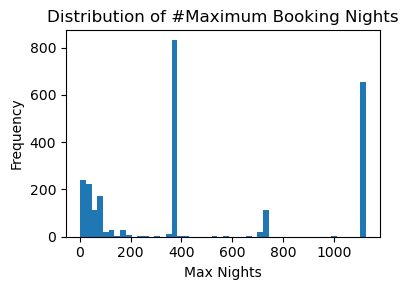

In [ ]:
feature = df_usable['maximum_nights']

# Compute key points
q1 = np.percentile(feature, 25)
median = np.percentile(feature, 50)
q3 = np.percentile(feature, 75)
min_val = feature.min()
max_val = feature.max()
iqr = q3 - q1

# --- Print numeric values ---
print("Boxplot summary statistics:")
print(f"Minimum: {min_val:.2f}")
print(f"Q1 (25th percentile): {q1:.2f}")
print(f"Median (50th percentile): {median:.2f}")
print(f"Q3 (75th percentile): {q3:.2f}")
print(f"Maximum: {max_val:.2f}")
print(f"IQR (Q3 - Q1): {iqr:.2f}")

fig, ax = plt.subplots(figsize=(4, 3))

ax.hist(
    feature,
    bins=50
)

ax.set_xlabel('Max Nights')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of #Maximum Booking Nights')

plt.tight_layout()
plt.show()

Max nights booking start from at least 2, which makes logical sense, with minimum nights starting from at least 1. There were also no semantic anomalies with minimum nights > maximum nights for a single listing.

Boxplot summary statistics:
Minimum: 0.11
Q1 (25th percentile): 1.38
Median (50th percentile): 2.20
Q3 (75th percentile): 3.43
Maximum: 6.58
IQR (Q3 - Q1): 2.05


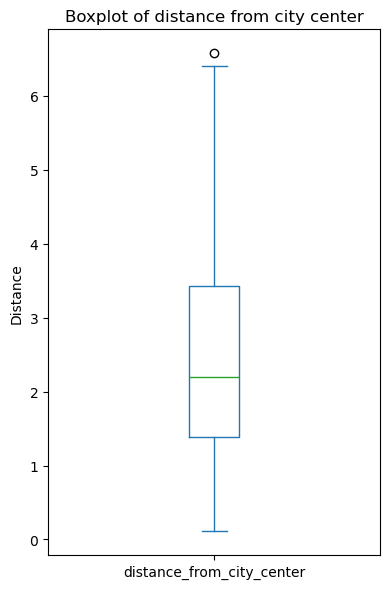

In [ ]:
# Boxplot for dist to city center
feature = df_usable['distance_from_city_center']

# Compute key points
q1 = np.percentile(feature, 25)
median = np.percentile(feature, 50)
q3 = np.percentile(feature, 75)
min_val = feature.min()
max_val = feature.max()
iqr = q3 - q1

# --- Print numeric values ---
print("Boxplot summary statistics:")
print(f"Minimum: {min_val:.2f}")
print(f"Q1 (25th percentile): {q1:.2f}")
print(f"Median (50th percentile): {median:.2f}")
print(f"Q3 (75th percentile): {q3:.2f}")
print(f"Maximum: {max_val:.2f}")
print(f"IQR (Q3 - Q1): {iqr:.2f}")

plt.figure(figsize=(4, 6))
feature.plot(kind="box")
plt.title("Boxplot of distance from city center")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

### Goals
We want to identify the top 5 distinct listings, which are provided for labelling on initialization (T4). To do so, we could use PCA to highlight the points furthest from each other. Data preparation steps required would be as follows:

### Data wrangling

To be completed here
1. Drop the irrelevant columns (see Data Characterization) for model training*
2. Scale the numeric features (existing on different scales with presence of outlier values)
3. Encode the categorical features 

*Features not used here (PCA) or in model training may still be relevant for completeness of webApp.

In [ ]:
df_model = df_usable.drop(columns=['id', 'name', 'host_id', 'host_name'])

num_cols = ["price", "distance_from_city_center", "latitude", "longitude", "minimum_nights", "maximum_nights", "accommodates", "bathrooms", "bedrooms", "beds"]
cat_cols = ['property_type', 'room_type', 'neighbourhood', 'neighbourhood_group']

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(), cat_cols)
])

X = preprocess.fit_transform(df_model)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

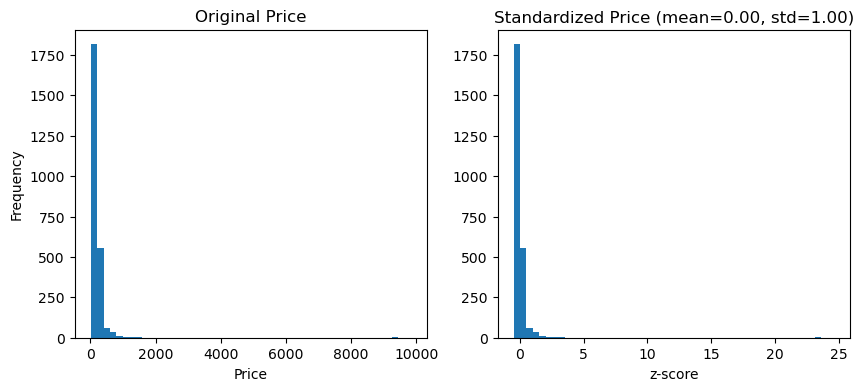

In [ ]:
feature_names = preprocess.get_feature_names_out()
price_feature_name = "num__price" # "num" = name of the transformer, "price" = original col
price_idx = list(feature_names).index(price_feature_name)

# Extract standardized price as a 1D array
price_col = X[:, price_idx]
price_std = price_col.toarray().ravel()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Original price
axes[0].hist(df_model["price"], bins=50)
axes[0].set_title("Original Price")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency")

# Standardized price
axes[1].hist(price_std, bins=50)
axes[1].set_title(f"Standardized Price (mean={price_std.mean():.2f}, std={price_std.std():.2f})")
axes[1].set_xlabel("z-score")

plt.show()

Above would be an example of the standardization to numerical features (using StandardScaler on 'price')

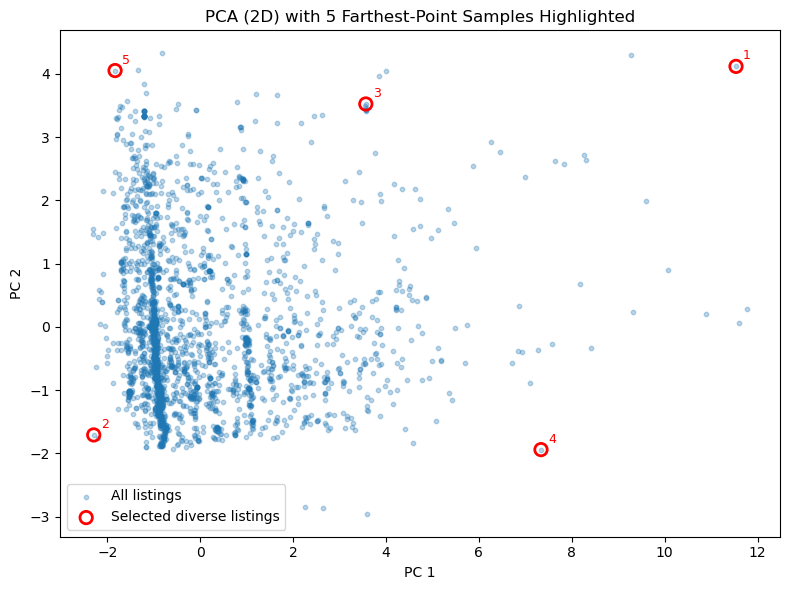

                id                                               name   price  \
2835  1.335420e+18  Detached house - central, 5 bdrs, garden, parking   153.0   
802   4.191887e+07  Charming Popup Hotel-Single Room (shared bathr...   122.0   
3035  1.394250e+18                   Functional 3BR Stay with Balcony   160.0   
2199  1.159310e+18         Urban Oasis: Lakefront Luxury Living, 1001  6662.0   
275   1.478192e+07           Quiet Zurich room in lovely neighborhood    85.0   

     neighbourhood        room_type  
2835       Seebach  Entire home/apt  
802        Rathaus     Private room  
3035       Seebach  Entire home/apt  
2199   Wollishofen  Entire home/apt  
275          Höngg     Private room  


In [ ]:
def farthest_point_sampling(X_2d, k):
    """
    X_2d: array of shape (n_samples, 2)
    Returns indices of k points that are as far apart as possible.
    """
    n = X_2d.shape[0]
    selected = []

    # Start with point having largest norm (furthest from origin)
    idx = np.linalg.norm(X_2d, axis=1).argmax()
    selected.append(idx)

    # Track minimum distance from each point to any selected point
    min_dists = np.linalg.norm(X_2d - X_2d[idx], axis=1)

    for _ in range(1, k):
        # Next point is the one with largest distance to current selected set
        idx = np.argmax(min_dists)
        selected.append(idx)

        # Update min distances given new selected point
        dists = np.linalg.norm(X_2d - X_2d[idx], axis=1)
        min_dists = np.minimum(min_dists, dists)

    return selected

k = 5
selected_idx = farthest_point_sampling(X_pca, k=k)

# -------- 3. Plot: scatter + highlight the 5 farthest points --------
plt.figure(figsize=(8, 6))

# All points
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    s=10,
    alpha=0.3,
    label="All listings"
)

# Highlight selected points
plt.scatter(
    X_pca[selected_idx, 0],
    X_pca[selected_idx, 1],
    s=80,
    facecolors="none",
    edgecolors="red",
    linewidths=2,
    label="Selected diverse listings"
)

# Label them 1..k
for i, idx in enumerate(selected_idx):
    plt.annotate(
        str(i + 1),
        (X_pca[idx, 0], X_pca[idx, 1]),
        textcoords="offset points",
        xytext=(5, 5),
        fontsize=9,
        color="red"
    )

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA (2D) with 5 Farthest-Point Samples Highlighted")
plt.legend()
plt.tight_layout()
plt.show()

# -------- 4. Get the corresponding rows from your original dataframe --------
initial_listings_df = df_usable.iloc[selected_idx]
print(initial_listings_df[["id", "name", "price", "neighbourhood", "room_type"]])

From the PCA, we identified the 5 most distinct listings using Farthest Point Sampling. We can see that most of the listing space exists in the bottom left, with some sparsity towards the top-right corner. Item 2 could possibly represent a smaller, cheaper listing, typical of AirBnb, while item 1 could be a rare luxury listing. All items lie on extreme regions in the feature space, ensuring that initial ratings collected will cover the widest range of features. Using these diverse listings for the initial elicitation of user ratings would provide a solid foundation for ranking subsequently.

### Reflection
The data wrangling process involved cleaning inconsistencies, engineering features, consolidating amenities, encoding categorical and scaling numerical variables. It ensured that all listings were represented in a structured format. These steps were essential for PCA, which is sensitive to variable scales and semantic noise. By creating a standardized feature matrix, the PCA projection could reliably capture relationships between listings and reveal underlying distribution of the dataset.

Looking forward, experimenting with certain decisions could improve the outcomes through justified data-driven decision-making. For example, the adjusting the cutoff for top amenities to include based on its impact to the PCA display.